# Replication of NetSurfP 2.0 with pyTorch

The purpose of this notebook is to replicate the current version of NetSurfP 2.0

**Load libraries**

The different libraries are initialized and pytorch is either configured to use the CPU or an available GPU.

In [1]:
import pylab
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from torch.autograd import Variable

# custom packages in parent folder
import os
import sys

computerome = os.getenv('UTILS', "..")
sys.path.append(computerome)

from notebooks.utils.early_stopping import EarlyStopping
from notebooks.utils.masked_batch_norm import MaskedBatchNorm1d

# debugging
import pdb

Setup CUDA device

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla V100-PCIE-16GB


## 1. Preparation of the data

Each dataset is compressed as a numpy zip and the dimensions of the dataset are as following: 

**[sequence, position, label]**

The labels are as following in the data (shown by index):
- [0:20] Amino Acids (sparse encoding) (Unknown residues are stored as an all-zero vector)
- [20:50] hmm profile
- [50] Seq mask (1 = seq, 0 = empty)
- [51] Disordered mask (0 = disordered, 1 = ordered)
- [52] Evaluation mask (For CB513 dataset, 1 = eval, 0 = ignore)
- [53] ASA (isolated)
- [54] ASA (complexed)
- [55] RSA (isolated)
- [56] RSA (complexed)
- [57:65] Q8 GHIBESTC (Q8 -> Q3: HHHEECCC)
- [65:67] Phi+Psi
- [67] ASA_max

### Loading the datasets

In [3]:
data_dir = "../../data/nsp2/training_data/"

train_hhblits = np.load(data_dir + "Train_HHblits.npz")
CB513_hhblits = np.load(data_dir + "CB513_HHblits.npz")
TS115_hhblits = np.load(data_dir + "TS115_HHblits.npz")
CASP12_hhblits = np.load(data_dir + "CASP12_HHblits.npz")

train_mmseqs = np.load(data_dir + "Train_MMseqs.npz")
CB513_mmseqs = np.load(data_dir +"CB513_MMseqs.npz")
TS115_mmseqs = np.load(data_dir + "TS115_MMseqs.npz")
CASP12_mmseqs = np.load(data_dir + "CASP12_MMseqs.npz")

In [4]:
# Parameters
data_dir = "/home/projects/ht3_aim/people/erikie/NSPThesis/data/nsp2/training_data"


### Custom Data loader class

A data loader class is created to load the NSP data into a DataLoader object. The DataLoader is a pytorch object, thats used to feed the data as batches. Which will be usefull when training and evaluating the NSP model. The NSPData class divides the dataset into input data and target labels.

In [5]:
class NSPData(Dataset):
    def __init__(self, dataset, indices = False):
        """ Constructor
        Args:
            X (np.array): The array that contains the training data
            y (np.array): The array that contains the test data
        """

        self.data = torch.tensor(dataset['data'][:, :, :50]).float()
        self.targets = torch.tensor(dataset['data'][:, :, 50:68]).float()
        self.lengths = torch.tensor([sum(target[:, 0] == 1) for target in self.targets])
        
        self.unknown_nucleotide_mask()
        
    def unknown_nucleotide_mask(self):
        """ Augments the target with a unknown nucleotide mask
            by finding entries that don't have any residue
        """
        
        # creates a mask based on the one hot encoding
        unknown_nucleotides = torch.max(self.data[:, :, :20], dim=2)
        unknown_nucleotides = unknown_nucleotides[0].unsqueeze(2)
        
        # merge the mask to first position of the targets
        self.targets = torch.cat([self.targets, unknown_nucleotides], dim=2)
        
    def __getitem__(self, index):
        """ Returns train and test data at an index
        Args:
            index (int): Index at the array
        """
        X = self.data[index]
        y = self.targets[index]
        lengths = self.lengths[index]
        
        return X, y, lengths
    
    def __len__(self):
        """Returns the length of the data"""
        return len(self.data)

# Holdout

It is important to have a training and validation set when training to evaluate the training performance. Therefore, a function that splits the dataset into training and evaluation is created for that purpose.

In [6]:
def split_dataset(batch_size, dataset):
    """ Splits the dataset into train and validation
    Args:
        batch_size (int): size of each batch
        dataset (np.array): dataset containing training data
        validation_fraction (float): the size of the validation set as a fraction
    """
    
    num_train = len(dataset['data'])
    train_indices = np.array(range(num_train))
    validation_indices = np.random.choice(train_indices, int(num_train*0.05), replace=False)
    
    train_indices = np.delete(train_indices, validation_indices)
    
    # subset the dataset
    train_idx, valid_idx = train_indices, validation_indices
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    training_set = DataLoader(NSPData(dataset), sampler=train_sampler, batch_size=batch_size)
    validation_set = DataLoader(NSPData(dataset), sampler=valid_sampler, batch_size=batch_size)
    
    return training_set, validation_set

**Instanciate data into the data loader class**

The training datasets are splitted into training and validation for training. Whereas the test sets are simply loaded, since they are independent datasets. The batch sizes is set to 15. The default training/validation split is 80/20.

In [7]:
batch_size = 15

In [8]:
# training and validation sets
train_hhblits = split_dataset(batch_size, train_hhblits)
train_mmseqs = split_dataset(batch_size, train_mmseqs)

# test sets
CB513_hhblits = DataLoader(NSPData(CB513_hhblits), batch_size=len(CB513_hhblits['data']))
TS115_hhblits = DataLoader(NSPData(TS115_hhblits), batch_size=len(TS115_hhblits['data']))
CASP12_hhblits = DataLoader(NSPData(CASP12_hhblits), batch_size=len(CASP12_hhblits['data']))

CB513_mmseqs = DataLoader(NSPData(CB513_mmseqs), batch_size=len(CB513_mmseqs['data']))
TS115_mmseqs = DataLoader(NSPData(TS115_mmseqs), batch_size=len(TS115_mmseqs['data']))
CASP12_mmseqs = DataLoader(NSPData(CASP12_mmseqs), batch_size=len(CASP12_mmseqs['data']))

## 2. The NSP Classifier

The input layer consists of one-hot encoded sequences (20 features amino acids) and a full HMM profile (20 features for amino acid profile, 7 features of state transition probabilities and 3 features for local alignment diversity) The input layer is followed by two layers of 1D CNN layers, that consist of 32 filters with a size of 129 and 257. Whereas the output of the last 1D CNN is concatenated with the initial input features. These residuals connections are used to achieve a better backpropagation without gradient degradation and a deeper network. The concatenated input+residuals is then applied to 2 bidirectional long  short-term memory (LSTM) layers with 1024 nodes, that outputs 2048 hidden neurons. The hidden neurons output is input to a fully connected (FC) layer to predict the 18 classes (RSA, SS8, SS3, φ, ψ, and disorder).

In [9]:
class NSP_Network(nn.Module):
    def __init__(self, init_channels, n_hidden):
        """ Initializes the model with the required layers
        Args:
            init_channels: The size of the incoming feature vector
            n_hidden: The amount of hidden neurons in the bidirectional lstm
        """
        super(NSP_Network, self).__init__()

        # CNN block
        self.conv1 = nn.Sequential(*[
            nn.Dropout(p=0.5),
            nn.Conv1d(in_channels=init_channels, out_channels=32, kernel_size=129, padding=64),
            nn.ReLU(),
        ])

        self.conv2 = nn.Sequential(*[
            nn.Dropout(p=0.5),
            nn.Conv1d(in_channels=init_channels, out_channels=32, kernel_size=257, padding=128),
            nn.ReLU(),
        ])
        
        self.batch_norm = MaskedBatchNorm1d(init_channels+64)

        # LSTM block
        self.lstm = nn.LSTM(input_size=init_channels+64, hidden_size=n_hidden, batch_first=True, \
                            num_layers=2, bidirectional=True, dropout=0.5)
        
        # add dropout to last layer
        self.lstm_dropout = nn.Dropout(p=0.5)

        # output block
        self.ss8 = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=8),
            #nn.Softmax(),
        ])
        self.ss3 = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=3),
            #nn.Softmax(),
        ])     
        self.disorder = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=2),
            #nn.Softmax(),
        ])
        self.rsa = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=1),
            nn.Sigmoid()
        ])
        self.phi = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=2),
            nn.Tanh()
        ])
        self.psi = nn.Sequential(*[
            nn.Linear(in_features=n_hidden*2, out_features=2),
            nn.Tanh()
        ])
        
    def forward(self, x, lengths, mask):
        """ Forwards the input through each layer in the model
        Args:
            x: input data containing sequences
            lengths: list containing each sequence length
            mask: data containing the sequence padding mask
        """
    
        _, length, _ = x.size()
        
        # calculate the residuals
        x = x.permute(0,2,1)
        
        r1 = self.conv1(x)
        r2 = self.conv2(x)
                
        # concatenate channels from residuals and input
        x = torch.cat([x, r1, r2], dim=1)
                                 
        # normalize
        x = self.batch_norm(x, mask.unsqueeze(1))
        
        # calculate double layer bidirectional lstm
        x = x.permute(0,2,1)
        
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = pad_packed_sequence(x, total_length=length, batch_first=True)
        
        x = self.lstm_dropout(x)
        
        # hidden neurons to classes
        ss8 = self.ss8(x)
        ss3 = self.ss3(x)
        disorder = self.disorder(x)
        rsa = self.rsa(x)
        phi = self.phi(x)
        psi = self.psi(x)

        return [ss8, ss3, disorder, rsa, phi, psi]

## 3. Loss function

To train the model, loss functions are required. The tasks SS8, SS3 and disorder uses cross entropy loss function and RSA, φ and ψ use mean squared error loss.

Weights were adjusted so each loss contribution was approximately equal by using homoscedastic uncertainty and optimizing the log variances for each prediction. (https://arxiv.org/abs/1705.07115)

In the forwarding of the MultiTaskLoss, filters are used to remove extrapolated zeros or disordered regions from the calculated losses.

The indexes for the labels are described in the data preparation section.

In [10]:
class MultiTaskLoss(nn.Module):
    """ Weighs multiple loss functions by considering the 
        homoscedastic uncertainty of each task """
    
    def __init__(self):
        super(MultiTaskLoss, self).__init__()
        self.log_vars = nn.Parameter(torch.zeros((6)))
        
    def mse(self, outputs, labels, mask):
        loss = torch.square(outputs - labels) * mask
        return torch.sum(loss) / torch.sum(mask)
    
    def cross_entropy(self, outputs, labels, mask):
        labels = labels.clone()
        labels[mask == 0] = -999
        
        return nn.CrossEntropyLoss(ignore_index=-999)(outputs, labels.long())
        
    def ss8(self, outputs, labels, mask):
        labels = torch.argmax(labels[:, :, 7:15], dim=2)
        outputs = outputs[0].permute(0, 2, 1)
        
        return self.cross_entropy(outputs, labels, mask)
        
    def ss3(self, outputs, labels, mask):
        structure_mask = torch.tensor([0,0,0,1,1,2,2,2]).to(device)

        labels = torch.max(labels[:, :, 7:15] * structure_mask, dim=2)[0].long()
        outputs = outputs[1].permute(0, 2, 1)
        
        return self.cross_entropy(outputs, labels, mask)
        
    def disorder(self, outputs, labels, mask):
        # apply the disorder loss
        labels = labels[:, :, 1].unsqueeze(2)
        labels = torch.argmax(torch.cat([labels, 1-labels], dim=2), dim=2)
        
        outputs = outputs[2].permute(0, 2, 1)
        
        return self.cross_entropy(outputs, labels, mask)
        
    def rsa(self, outputs, labels, mask):
        labels = labels[:, :, 5].unsqueeze(2)
        outputs = outputs[3]
        
        mask = mask.unsqueeze(2)
        
        return self.mse(outputs, labels, mask)
        
    def phi(self, outputs, labels, mask):
        labels = labels[:, :, 15].unsqueeze(2)
        outputs = outputs[4]
        
        mask = mask * (labels != 360).squeeze(2).int()
        mask = torch.cat(2*[mask.unsqueeze(2)], dim=2)
        
        loss = self.mse(outputs.squeeze(2), torch.cat((torch.sin(dihedral_to_radians(labels)), torch.cos(dihedral_to_radians(labels))), dim=2).squeeze(2), mask)
        return loss
        
    def psi(self, outputs, labels, mask):
        labels = labels[:, :, 16].unsqueeze(2)
        outputs = outputs[5]
        
        mask = mask * (labels != 360).squeeze(2).int()
        mask = torch.cat(2*[mask.unsqueeze(2)], dim=2)
        
        loss = self.mse(outputs.squeeze(2), torch.cat((torch.sin(dihedral_to_radians(labels)), torch.cos(dihedral_to_radians(labels))), dim=2).squeeze(2), mask)
        return loss

    def forward(self, outputs, labels, weighted=True):
        """ Forwarding of the multitaskloss input
        Args:
            outputs (torch.tensor): output data from model
            labels (torch.tensor): corresponding labels for the output
        """

        # filters
        zero_mask = labels[:, :, 0]
        disorder_mask = labels[:, :, 1]
        unknown_mask = labels[:, :, -1]
        
        # weighted losses
        ss8 = self.ss8(outputs, labels, zero_mask) * 1
        ss3 = self.ss3(outputs, labels, zero_mask) * 5
        dis = self.disorder(outputs, labels, zero_mask) * 5
        rsa = self.rsa(outputs, labels, zero_mask * disorder_mask * unknown_mask) * 100
        phi = self.phi(outputs, labels, zero_mask * disorder_mask * unknown_mask) * 5
        psi = self.psi(outputs, labels, zero_mask * disorder_mask * unknown_mask) * 5
        
        loss = torch.stack([ss8, ss3, dis, rsa, phi, psi])
        
        return loss.sum()

### Utils

The model trains phi and psi into each their vector that will contain calculated cos and sin values from the angle. Pytorch works with radians, so these helper functions helps converting dihedral angle values into radians and cos and sin radian values back to a dihedral angle.

In [11]:
def dihedral_to_radians(angle):
    """ Converts angles to radians
    Args:
        angles (1D Tensor): vector with angle values
    """
    return angle*np.pi/180
    
def arctan_dihedral(sin, cos):
    """ Converts sin and cos back to diheral angles
    Args:
        sin (1D Tensor): vector with sin values 
        cos (1D Tensor): vector with cos values
    """
    result = torch.where(cos >= 0, torch.arctan(sin/cos), torch.arctan(sin/cos)+np.pi)
    result = torch.where((sin <= 0) & (cos <= 0), result-np.pi*2, result)
    
    return result*180/np.pi

## 5. Training

Instanciating the model, criterion and optimizer

In [12]:
def init_model(initial_channels, hidden_neurons, learning_rate):
    """ Initializes a model, criterion and optimizer 
    Args:
        initial_channels (int): amount of initial inputs for the model
        hidden_neurons (int): amount of hidden neurons in the model
    """
    nsp_net = NSP_Network(initial_channels, hidden_neurons)
    criterion = MultiTaskLoss()

    # enable cuda on model and criterion if possible
    if device.type != "cpu":
        nsp_net.cuda(device)
        criterion.cuda(device)

    # optimizer for model and criterion
    optimizer = optim.Adam([{"params" : criterion.parameters()}, {"params" : nsp_net.parameters()}], lr=learning_rate)
    
    return nsp_net, criterion, optimizer

The model is trained by iterating through the training dataset for an amount of epochs. The model is trained using backpropagation using the multiple task loss.

In [13]:
def training(epochs, model, criterion, optimizer, dataset):
    # iterate over the dataset multiple times
    training_loss = []
    validation_loss = []
        
    train, test = dataset

    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train), epochs=epochs)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=3, verbose=True)

    for epoch in range(epochs):
        print('Epoch:', epoch + 1,' of ', epochs)

        # training of the model 
        running_loss = 0.0
        for i, data in enumerate(train, 0):

            # move data tensors to GPU if possible
            inputs, labels, lengths = data
            inputs, labels = inputs.to(device), labels.to(device)  
            
            padding = labels[:, :, 0]
            outputs = model(inputs, lengths, padding)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # backpropagation by custom criterion
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            #scheduler.step()

            running_loss += loss.item()

        training_loss.append(running_loss / len(train))
        print("Training loss: ", round(training_loss[epoch], 3))

        #validation of the model
        running_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(test, 0):
                
                # move data tensors to GPU if possible
                inputs, labels, lengths = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                padding = labels[:, :, 0]
                outputs = model(inputs, lengths, padding)

                loss = criterion(outputs, labels)

                running_loss += loss.item()

        validation_loss.append(running_loss / len(test))
        print("Validation loss: ", round(validation_loss[epoch], 3))

        early_stopping(validation_loss[epoch], model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
        
    print('Finished Training')
    
    return training_loss, validation_loss

The training loss and validation loss are visualized to evaluate the training performance.

In [14]:
def plot_loss(training_loss, validation_loss, title):
    pylab.plot(training_loss)
    pylab.plot(validation_loss)
    pylab.xlabel('Epochs')
    pylab.ylabel('Loss [sum]')
    pylab.legend(('Training loss', 'Validation loss'))
    pylab.title(title)
    pylab.show()

Start the training

Epoch: 1  of  100
Training loss:  10.206
Validation loss:  8.925
Validation loss decreased (inf --> 8.925399).  Saving model ...
Epoch: 2  of  100
Training loss:  8.687
Validation loss:  8.415
Validation loss decreased (8.925399 --> 8.414929).  Saving model ...
Epoch: 3  of  100
Training loss:  8.242
Validation loss:  8.322
Validation loss decreased (8.414929 --> 8.321767).  Saving model ...
Epoch: 4  of  100
Training loss:  7.946
Validation loss:  8.055
Validation loss decreased (8.321767 --> 8.054566).  Saving model ...
Epoch: 5  of  100
Training loss:  7.645
Validation loss:  7.919
Validation loss decreased (8.054566 --> 7.918506).  Saving model ...
Epoch: 6  of  100
Training loss:  7.333
Validation loss:  7.791
Validation loss decreased (7.918506 --> 7.790700).  Saving model ...
Epoch: 7  of  100
Training loss:  7.016
Validation loss:  8.036
EarlyStopping counter: 1 out of 3
Epoch: 8  of  100
Training loss:  6.709
Validation loss:  7.821
EarlyStopping counter: 2 out of 3
Epoch: 9  

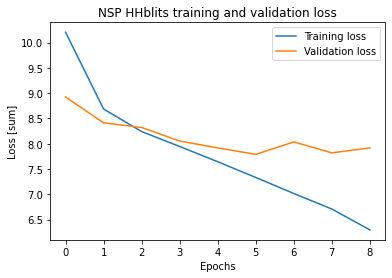

Epoch: 1  of  100
Training loss:  10.242
Validation loss:  8.822
Validation loss decreased (inf --> 8.822194).  Saving model ...
Epoch: 2  of  100
Training loss:  8.528
Validation loss:  8.397
Validation loss decreased (8.822194 --> 8.397294).  Saving model ...
Epoch: 3  of  100
Training loss:  8.081
Validation loss:  7.994
Validation loss decreased (8.397294 --> 7.993682).  Saving model ...
Epoch: 4  of  100
Training loss:  7.737
Validation loss:  7.92
Validation loss decreased (7.993682 --> 7.919536).  Saving model ...
Epoch: 5  of  100
Training loss:  7.438
Validation loss:  7.934
EarlyStopping counter: 1 out of 3
Epoch: 6  of  100
Training loss:  7.161
Validation loss:  7.689
Validation loss decreased (7.919536 --> 7.688869).  Saving model ...
Epoch: 7  of  100
Training loss:  6.814
Validation loss:  7.808
EarlyStopping counter: 1 out of 3
Epoch: 8  of  100
Training loss:  6.49
Validation loss:  7.765
EarlyStopping counter: 2 out of 3
Epoch: 9  of  100
Training loss:  6.116
Validat

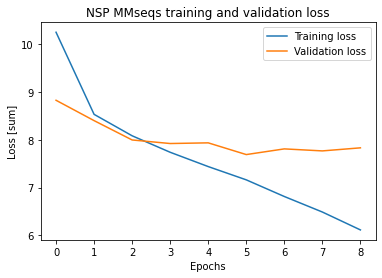

In [15]:
epochs = 100

initial_channels = 50
hidden_neurons = 1024
learning_rate = 5e-4

nsp_hhblits = init_model(initial_channels, hidden_neurons, learning_rate)

training_loss, evaluation_loss = training(epochs, nsp_hhblits[0],
                                                    nsp_hhblits[1],
                                                    nsp_hhblits[2],
                                                    train_hhblits)

plot_loss(training_loss, evaluation_loss, "NSP HHblits training and validation loss")

nsp_mmseqs = init_model(initial_channels, hidden_neurons, learning_rate)

training_loss, evaluation_loss = training(epochs, nsp_mmseqs[0], 
                                          nsp_mmseqs[1], 
                                          nsp_mmseqs[2],
                                          train_mmseqs)

plot_loss(training_loss, evaluation_loss, "NSP MMseqs training and validation loss")

## 5. Evaluation

Evaluation functions are created to evaluate the models performance.

In [16]:
def fpr(pred, labels):
    """ False positive rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tn = sum((pred == 0) & (labels == 0))
    
    return (fp/(fp+tn)).item()

def fnr(pred, labels):
    """ False negative rate
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fn = sum((pred == 0) & (labels == 1))
    tp = sum((pred == 1) & (labels == 1))
    
    return (fn/(fn+tp)).item()

def mcc(pred, labels):
    """ Mathews correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted binary numeric values
        labels (1D Tensor): vector with correct binary numeric values
    """
    fp = sum((pred == 1) & (labels == 0))
    tp = sum((pred == 1) & (labels == 1))
    fn = sum((pred == 0) & (labels == 1))
    tn = sum((pred == 0) & (labels == 0))
    
    return ((tp*tn-fp*fn)/torch.sqrt(((tp+fp)*(fn+tn)*(tp+fn)*(fp+tn)).float())).item()

def pcc(pred, labels):
    """ Pearson correlation coefficient
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    x = pred - torch.mean(pred)
    y = labels - torch.mean(labels)
    
    return (torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)))).item()

def mae(pred, labels):
    """ Mean absolute error
    Args:
        inputs (1D Tensor): vector with predicted numeric values
        labels (1D Tensor): vector with correct numeric values
    """
    err = torch.abs(labels - pred)
    return torch.mean(torch.fmin(err, 360-err)).item()

def accuracy(pred, labels):
    """ Accuracy coefficient
    Args:
        inputs (1D Tensor): vector with predicted integer values
        labels (1D Tensor): vector with correct integer values
    """
    
    return (sum((pred == labels)) / len(labels)).item()

Seperate datasets are used to evaluate the model. Here is each class evaluated and the prediction benchmarks for the trained model are found.

In [17]:
def evaluate_ss8(outputs, labels, mask):
    labels = torch.argmax(labels[:, :, 7:15], dim=2)[mask == 1]
    outputs = torch.argmax(outputs, dim=2)[mask == 1]
        
    return accuracy(outputs, labels)
    
def evaluate_ss3(outputs, labels, mask):
    structure_mask = torch.tensor([0,0,0,1,1,2,2,2])

    labels = torch.max(labels[:, :, 7:15] * structure_mask, dim=2)[0].long()[mask == 1]
    outputs = torch.argmax(outputs, dim=2)[mask == 1]
        
    return accuracy(outputs, labels)
    
def evaluate_dis(outputs, labels, mask, metric="fpr"):
    labels = labels[:, :, 1].unsqueeze(2)
    labels = torch.argmax(torch.cat([labels, 1-labels], dim=2), dim=2)[mask == 1]
    outputs = torch.argmax(outputs, dim=2)[mask == 1]

    if metric == "fpr":
        return fpr(outputs, labels)
    else:
        return mcc(outputs, labels)
    
def evaluate_rsa(outputs, labels, mask):
    labels = labels[:, :, 5].unsqueeze(2)[mask == 1]
    outputs = outputs[mask == 1]
        
    return pcc(outputs, labels)

def evaluate_asa(outputs, labels, mask):
    outputs = (outputs * labels[:, :, 17].unsqueeze(2))[mask == 1]
    labels = labels[:, :, 3].unsqueeze(2)[mask == 1]
    
    return pcc(outputs, labels)

def evaluate_phi(outputs, labels, mask):    
    labels = labels[:, :, 15]
    
    mask = mask * (labels != 360).int()
    labels = labels[mask == 1]
    
    outputs = arctan_dihedral(outputs[:, :, 0], outputs[:, :, 1])[mask == 1]
    
    return mae(outputs, labels)
    
def evaluate_psi(outputs, labels, mask):
    labels = labels[:, :, 16]
    
    mask = mask * (labels != 360).int()
    labels = labels[mask == 1]
    
    outputs = arctan_dihedral(outputs[:, :, 0], outputs[:, :, 1])[mask == 1]
    
    return mae(outputs, labels)

def evaluation(model, dataset):    
    # iterate through the evaluation dataset
    with torch.no_grad():
        for data in dataset:
            # move data tensors to GPU if possible
            inputs, labels, lengths = data
            
            # add evaluation mask to the masks
            evaluation_mask = labels[:, :, 2]
            
            zero_mask = labels[:, :, 0] * evaluation_mask
            disorder_mask = labels[:, :, 1]
            unknown_mask = labels[:, :, -1]
            
            # get predictions
            model = model.to('cpu')
            predictions = model(inputs, lengths, zero_mask) # predict values
            
            # move predictions to cpu
            for i in range(len(predictions)):
                predictions[i] = predictions[i].cpu()
                
            labels = labels.cpu()
            zero_mask = zero_mask.cpu()
            disorder_mask = disorder_mask.cpu()
            unknown_mask = unknown_mask.cpu()
            
            # evaluate
            ss8 = evaluate_ss8(predictions[0], labels, zero_mask)
            ss3 = evaluate_ss3(predictions[1], labels, zero_mask)
            dis_fpr = evaluate_dis(predictions[2], labels, zero_mask, metric="fpr")
            dis_mcc = evaluate_dis(predictions[2], labels, zero_mask, metric="mcc")
            rsa = evaluate_rsa(predictions[3], labels, zero_mask * disorder_mask * unknown_mask)
            asa = evaluate_asa(predictions[3], labels, zero_mask * disorder_mask * unknown_mask)
            phi = evaluate_phi(predictions[4], labels, zero_mask * disorder_mask * unknown_mask)
            psi = evaluate_psi(predictions[5], labels, zero_mask * disorder_mask * unknown_mask)
            
            torch.cuda.empty_cache()
            
            print("RSA (PCC): {}".format(round(rsa, 3)))
            print("ASA (PCC): {}".format(round(asa, 3)))
            print("SS8 [Q8]: {}".format(round(ss8, 3)))
            print("SS3 [Q3]: {}".format(round(ss3, 3)))
            print("Disorder (MCC): {}".format(round(dis_mcc, 2)))
            print("Disorder (FNR): {}".format(round(dis_fpr, 3)))
            print("Phi (MAE): {}".format(round(phi, 3)))
            print("Psi (MAE): {}".format(round(psi, 3)))

The models are evaluated

In [18]:
print("Evaluation HHblits...")

print("\nCB513")
evaluation(nsp_hhblits[0], CB513_hhblits)
print("\nTS115")
evaluation(nsp_hhblits[0], TS115_hhblits)
print("\nCASP12")
evaluation(nsp_hhblits[0], CASP12_hhblits)

print("\nEvaluation MMseqs...")

print("\nCB513")
evaluation(nsp_mmseqs[0], CB513_mmseqs)
print("\nTS115")
evaluation(nsp_mmseqs[0], TS115_mmseqs)
print("\nCASP12")
evaluation(nsp_mmseqs[0], CASP12_mmseqs)

Evaluation HHblits...

CB513
RSA (PCC): 0.765
ASA (PCC): 0.783
SS8 [Q8]: 0.697
SS3 [Q3]: 0.838
Disorder (MCC): 0.04
Disorder (FNR): 0.006
Phi (MAE): 21.075
Psi (MAE): 30.896

TS115
RSA (PCC): 0.754
ASA (PCC): 0.777
SS8 [Q8]: 0.726
SS3 [Q3]: 0.841
Disorder (MCC): 0.61
Disorder (FNR): 0.01
Phi (MAE): 18.425
Psi (MAE): 28.838

CASP12
RSA (PCC): 0.7
ASA (PCC): 0.717
SS8 [Q8]: 0.693
SS3 [Q3]: 0.818
Disorder (MCC): 0.62
Disorder (FNR): 0.018
Phi (MAE): 21.128
Psi (MAE): 33.601

Evaluation MMseqs...

CB513
RSA (PCC): 0.776
ASA (PCC): 0.792
SS8 [Q8]: 0.697
SS3 [Q3]: 0.835
Disorder (MCC): 0.06
Disorder (FNR): 0.011
Phi (MAE): 20.956
Psi (MAE): 30.597

TS115
RSA (PCC): 0.764
ASA (PCC): 0.786
SS8 [Q8]: 0.73
SS3 [Q3]: 0.844
Disorder (MCC): 0.63
Disorder (FNR): 0.011
Phi (MAE): 17.966
Psi (MAE): 27.58

CASP12
RSA (PCC): 0.702
ASA (PCC): 0.713
SS8 [Q8]: 0.685
SS3 [Q3]: 0.817
Disorder (MCC): 0.66
Disorder (FNR): 0.023
Phi (MAE): 21.345
Psi (MAE): 33.829
